In [90]:
%matplotlib inline

from pyspark.sql import SparkSession, functions

import numpy as np
import scipy
import scipy.linalg as la
import doctest
import re
import random
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("Experiment6").getOrCreate()
sc = spark.sparkContext

# Load the Data

In [2]:
userLibrariesRDD = \
    sc.textFile('/home/jovyan/work/users_libraries.txt') \
        .map(lambda l: l.split(';')) \
        .mapValues(lambda value: value.split(','))

userLibrariesRDD.take(1)

[('28d3f81251d94b09735497477a5e4e02',
  ['3929762',
   '503574',
   '5819422',
   '4238883',
   '5788061',
   '462949',
   '635215',
   '635216',
   '4810441',
   '3481823',
   '4165233',
   '3366480',
   '5984302',
   '4238942',
   '5490453',
   '4636156',
   '5996865',
   '4194836',
   '5828780',
   '4450195'])]

In [3]:
paperColumns = ['id', 'type', 'journal', 'book', 'series', 'publisher', 'pages', 'volume', 
                 'number', 'year', 'month', 'postedate', 'address', 'title', 'abstract']
papersDF = \
    spark.read.csv('/home/jovyan/work/papers.csv') \
        .toDF(*paperColumns)

papersDF.first()

Row(id='80546', type='article', journal='biology and philosophy', book=None, series=None, publisher=None, pages='17', volume='19', number='2', year='2004', month='mar', postedate='2005-01-26 21:35:21', address=None, title='the arbitrariness of the genetic code', abstract="the genetic code has been regarded as arbitrary in the sense that the codon-amino acid assignments could be different than they actually are. this general idea has been spelled out differently by previous, often rather implicit accounts of arbitrariness. they have drawn on the frozen accident theory, on evolutionary contingency, on alternative causal pathways, and on the absence of direct stereochemical interactions between codons and amino acids. it has also been suggested that the arbitrariness of the genetic code justifies attributing semantic information to macromolecules, notably to {dna}. i argue that these accounts of arbitrariness are unsatisfactory. i propose that the code is arbitrary in the sense of jacques

# Exercise 6.1

a) Here we create a dataset of triples `(user_id, paper_id, label)`. Creating the positive labels to the dataset is straightforward:

In [10]:
triplesDatasetPositives = \
    userLibrariesRDD.flatMapValues(lambda l: l) \
        .map(lambda pair: (pair, 1))

triplesDatasetPositives.take(4)

[(('28d3f81251d94b09735497477a5e4e02', '3929762'), 1),
 (('28d3f81251d94b09735497477a5e4e02', '503574'), 1),
 (('28d3f81251d94b09735497477a5e4e02', '5819422'), 1),
 (('28d3f81251d94b09735497477a5e4e02', '4238883'), 1)]

Creating the negative labels requires more computation. To do so, we need all the paper IDs, as well as a function to sample from papers outside the library randomly.

In [32]:
paperIDsBC = sc.broadcast(papersDF.select('id').rdd.map(lambda x: x.id).collect())

paperIDsBC.value[:4]

['80546', '5842862', '1242600', '3467077']

In [38]:
def sampleNegatives(positives):
    positivesSet = set(positives)
    filtered = list(filter(lambda i: i not in positivesSet, paperIDsBC.value))
    return random.sample(filtered, len(positives))

# sampleNegatives(paperIDsRDD.take(4))
sampleNegatives(userLibrariesRDD.first()[1])

['118570',
 '1468550',
 '9091517',
 '1387568',
 '4369920',
 '841568',
 '950610',
 '3815481',
 '3494700',
 '1350937',
 '6398238',
 '3111684',
 '745197',
 '2468627',
 '6391463',
 '6930514',
 '1870365',
 '6963142',
 '1811386',
 '445587']

Now, with the function defined, we can create the negative (`0`) labels.

In [39]:
triplesDatasetNegatives = \
    userLibrariesRDD.flatMapValues(lambda l: sampleNegatives(l)) \
    .map(lambda pair: (pair, 0))

triplesDatasetNegatives.take(4)

[(('28d3f81251d94b09735497477a5e4e02', '2805215'), 0),
 (('28d3f81251d94b09735497477a5e4e02', '4992552'), 0),
 (('28d3f81251d94b09735497477a5e4e02', '6356642'), 0),
 (('28d3f81251d94b09735497477a5e4e02', '821356'), 0)]

In [41]:
triplesDataset = sc.union([triplesDatasetPositives, triplesDatasetNegatives])

b) With the dataset ready, we can now extract the features.

In [149]:
# First, we extract the user features.
def extractUserFeatures(articlePagesList):
    lengths = [int(x[1][0]) for x in articlePagesList]
    return [len(articlePagesList), np.mean(lengths)]

userLibrariesInvertedRDD = userLibrariesRDD.flatMapValues(lambda l: l).map(lambda pair: (pair[1], pair[0]))

usersFeaturesMapRDD = \
    papersDF.select('id', 'pages') \
        .rdd \
        .map(lambda paper: (paper.id, paper.pages)) \
        .filter(lambda pair: pair[1] is not None and pair[1].isnumeric()) \
        .join(userLibrariesInvertedRDD) \
        .groupBy(lambda pair: pair[1][1]) \
        .mapValues(extractUserFeatures)

usersFeaturesMapRDD.take(1)

[('dfe220b4efb90d9715b5bb63ade6e8a7', [3, 6.333333333333333])]

# Exercise 6.2

To be able to filter the data correcly, we need to observe it first.

In [65]:
print('no. of null pages:', papersDF.filter('pages is null').count())
print('no. of null years:', papersDF.filter('year is null').count())
print('no. of null types:', papersDF.filter('type is null').count())

Number of null pages: 53126
Number of null years: 19
Number of null types: 0


## 6.2.1 Pages

The observation above shows that the field `pages` has a lot of anomality. Some 30% of the papers are missing this field, and some of them have malformed data for that field:

In [129]:
# Observe anomalities in the field pages
print('no. of papers:', papersDF.count())
print('no. of papers pages = null:', papersDF.filter('pages is null').count())
print('no. of papers pages = NaN :', 
      papersDF.filter('pages is not null').rdd.map(lambda r: r.pages).filter(lambda x: not x.isnumeric()).count())
print('no. of papers pages = zero:', papersDF.filter("pages = '0'").count())

no. of papers: 172079
no. of papers pages = null: 53126
no. of papers pages = NaN : 244
no. of papers pages = zero: 0


In addition to the unclean data, there are some outliers in the data. There are four enormous number in these fields, affect the _mean_ big time. We can also discard the last two percent of the data in our calculations as the outliers.

[4748.0, 5602.0, 6607.0, 6700.0, 8999.0, 9293.0, 12428999.0, 15000939.0, 19815531.0, 20109963.0]
1.0 9.0 42.0
10.455230226146407
12.635533465313172


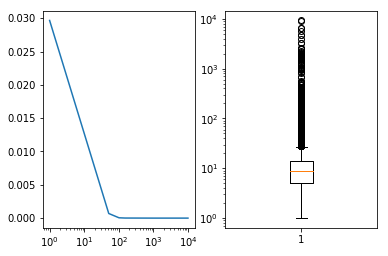

In [130]:
# Collect the numerical pages from the dataframe
papersPagesList = \
    papersDF.filter('pages is not null') \
        .rdd \
        .map(lambda row: row.pages) \
        .filter(lambda pages: pages.isnumeric()) \
        .map(lambda pages: float(pages)) \
        .collect()

# To find possible outliers, print the 10 largest numbers
sortedPapersPagesList = sorted(papersPagesList)
print(sortedPapersPagesList[-10:])

# Plot the distribution and the boxplot
from scipy.stats import gaussian_kde as KDE
papersPagesDensity = KDE(sortedPapersPagesList[:-4])
xs = np.linspace(1,10000,200)

plt.subplot(121)
plt.xscale('log')
plt.plot(xs, papersPagesDensity(xs))

plt.subplot(122)
plt.yscale('log')
plt.boxplot(sortedPapersPagesList[:-4])

# Find the 2nd, 50th, and 98th percentiles, as well as mean in the middle part (2—98)
print(np.percentile(sortedPapersPagesList, 2), 
      np.median(sortedPapersPagesList),
      np.percentile(sortedPapersPagesList, 98))
print(np.mean(list(filter(lambda x: x < 43, sortedPapersPagesList))))
print(np.mean(sortedPapersPagesList[:-4]))

The median of `pages` is $9$. The mean after removing the outliers rounds up to $10$, and without rounds up to $13$. It shows that using _median_ instead of _mean_ would have been advantageous from the beginning.

# 6.2.2 Year

In [131]:
papersYearRDD = \
    papersDF.filter('year is not null') \
        .rdd \
        .map(lambda row: row.year) \
        .filter(lambda year: year.isnumeric()) \
        .map(lambda year: float(year)) \
        .filter(lambda year: 1400 < year < 2020)  # without this, mean would be 3212.38
print('years mean  :', papersYearRDD.mean())
print('years median:', np.median(papersYearRDD.collect()))

years mean  : 2003.9430744466324
years median: 2006.0


# 6.2.3 Type

In [137]:
papersTypeCount = \
    papersDF.select('type') \
        .rdd \
        .map(lambda row: (row.type, 1)) \
        .reduceByKey(lambda x, y: x+y) \
        .sortBy(lambda pair: pair[1]) \
        .collect()

papersTypeDict = [pair[0] for pair in papersTypeCount]

papersTypeCount

[('booklet', 46),
 ('manual', 69),
 ('mastersthesis', 119),
 ('phdthesis', 375),
 ('inbook', 665),
 ('techreport', 1130),
 ('unpublished', 1491),
 ('electronic', 1659),
 ('proceedings', 2204),
 ('incollection', 3612),
 ('misc', 5365),
 ('book', 9553),
 ('inproceedings', 17019),
 ('article', 128772)]

# 6.2.4 Imputer
There is a fancy Spark imputer, but it requires numerical values to be able to use _mean_. To be able to use it, we should transform the DF, and if we must transform the DF, we can impute manually, althogether. Furthermore, we need to round up the final value of the mean, which does not seem like Spark does automatically.

In [147]:
def extractPaperFeatures(row):
    pages = int(row.pages) if row.pages is not None and row.pages.isnumeric() else 10
    year = int(row.year) if row.year is not None and row.year.isnumeric() else 2004
    hotType = [1 if row.type == cat else 0 for cat in papersTypeDict]
    return [pages, year] + hotType

extractPaperFeatures(papersDF.first())

[17, 2004, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

# 6.2.5 Transform Data
Now we are ready to generate the dataset. To do so, we create two local hashmaps to transform the id-id-label dataset into a vector-label data.

In [150]:
usersFeaturesMap = usersFeaturesMapRDD.collectAsMap()
papersFeaturesMap = \
    papersDF.rdd \
        .map(lambda row: (row.id, extractPaperFeatures(row))) \
        .collectAsMap()

In [152]:
labledDataSet = \
    triplesDataset.map(lambda pair: (usersFeaturesMap[pair[0][0]] + papersFeaturesMap[pair[0][1]], pair[1]))

labledDataSet.take(4)

[([1, 54.0, 10, 2007, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 1),
 ([1, 54.0, 10, 2006, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 1),
 ([1, 54.0, 10, 2009, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 1),
 ([1, 54.0, 54, 2009, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 1)]